In [ ]:
!wget https://raw.githubusercontent.com/openforcefield/2023-workshop-vignettes/update-install-instructions/colab_setup.ipynb
%run colab_setup.ipynb
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [1]:
from typing import Iterable, Optional, Union

from IPython.display import SVG
from openff.toolkit import ForceField, Molecule
from openff.toolkit.topology import FrozenMolecule
from openff.units import unit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdDepictor import Compute2DCoords

In [2]:
DEFAULT_WIDTH = 980
DEFAULT_HEIGHT = 400

Color = Iterable[float]
BondIndices = tuple[int, int]

In [3]:
def draw_molecule(
    molecule: Union[str, Molecule, Chem.Mol],
    image_width: int = DEFAULT_WIDTH,
    image_height: int = DEFAULT_HEIGHT,
    highlight_atoms: Optional[Union[list[int], dict[int, Color]]] = None,
    highlight_bonds: Optional[
        Union[list[BondIndices], dict[BondIndices, Color]]
    ] = None,
    atom_notes: Optional[dict[int, str]] = None,
    bond_notes: Optional[dict[BondIndices, str]] = None,
    explicit_hydrogens: Optional[bool] = None,
    color_by_element: Optional[bool] = None,
) -> SVG:
    """Draw a molecule
    Parameters
    ==========
    molecule
        The molecule to draw.
    image_width
        The width of the resulting image in pixels.
    image_height
        The height of the resulting image in pixels.
    highlight_atoms
        A list of atom indices to highlight, or a map from indices to colors.
        Colors should be given as triplets of floats between 0.0 and 1.0.
    highlight_atoms
        A list of pairs of atom indices indicating bonds to highlight, or a map
        from index pairs to colors. Colors should be given as triplets of floats
        between 0.0 and 1.0.
    atom_notes
        A map from atom indices to a string that should be printed near the
        atom.
    bond_notes
        A map from atom index pairs to a string that should be printed near the
        bond.
    explicit_hydrogens
        If ``False``, allow uncharged monovalent hydrogens to be hidden. If
        ``True``, make all hydrogens explicit. If ``None``
    color_by_element
        If True, color heteroatoms according to their element; if False, the
        image will be black and white. By default, uses black and white when
        highlight_atoms or highlight_bonds is provided, and color otherwise.
    Raises
    ======
    KeyError
        When an atom or bond in highlight_atoms or highlight_bonds is missing
        from the image, including when it is present in the molecule but hidden.
    """
    if isinstance(molecule, FrozenMolecule):
        rdmol = molecule.to_rdkit()
    elif isinstance(molecule, str):
        rdmol = Molecule.from_smiles(molecule).to_rdkit()
    else:
        rdmol = molecule

    if color_by_element is None:
        color_by_element = highlight_atoms is None and highlight_bonds is None

    if explicit_hydrogens is None:
        idx_map = {i: i for i in range(rdmol.GetNumAtoms())}
    elif explicit_hydrogens:
        idx_map = {i: i for i in range(rdmol.GetNumAtoms())}
        rdmol = Chem.AddHs(rdmol, explicitOnly=True)
    else:
        idx_map = {
            old: new
            for new, old in enumerate(
                a.GetIdx()
                for a in rdmol.GetAtoms()
                if a.GetAtomicNum() != 1 and a.GetMass() != 1
            )
        }
        rdmol = Chem.RemoveHs(rdmol, updateExplicitCount=True)

    if highlight_atoms is None:
        highlight_atoms = []
        highlight_atom_colors = None
    elif isinstance(highlight_atoms, dict):
        highlight_atom_colors = {
            idx_map[i]: tuple(c) for i, c in highlight_atoms.items() if i in idx_map
        }
        highlight_atoms = list(highlight_atoms.keys())
    else:
        highlight_atoms = [idx_map[i] for i in highlight_atoms if i in idx_map]
        highlight_atom_colors = None

    if highlight_bonds is None:
        highlight_bonds = []
        highlight_bond_colors = None
    elif isinstance(highlight_bonds, dict):
        highlight_bond_colors = {
            rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b]).GetIdx(): tuple(v)
            for (i_a, i_b), v in highlight_bonds.items()
            if i_a in idx_map and i_b in idx_map
        }

        highlight_bonds = list(highlight_bond_colors.keys())
    else:
        highlight_bonds = [
            rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b])
            for i_a, i_b in highlight_bonds
            if i_a in idx_map and i_b in idx_map
        ]
        highlight_bond_colors = None

    if bond_notes is not None:
        for (i_a, i_b), note in bond_notes.items():
            if i_a not in idx_map or i_b not in idx_map:
                continue
            rdbond = rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b])
            rdbond.SetProp("bondNote", note)

    if atom_notes is not None:
        for i, note in atom_notes.items():
            if i not in idx_map:
                continue
            rdatom = rdmol.GetAtomWithIdx(idx_map[i])
            rdatom.SetProp("atomNote", note)

    Compute2DCoords(rdmol)

    drawer = Draw.MolDraw2DSVG(image_width, image_height)

    draw_options = drawer.drawOptions()
    if not color_by_element:
        draw_options.useBWAtomPalette()

    drawer.DrawMolecule(
        rdmol,
        highlightAtoms=highlight_atoms,
        highlightAtomColors=highlight_atom_colors,
        highlightBonds=highlight_bonds,
        highlightBondColors=highlight_bond_colors,
    )
    drawer.FinishDrawing()

    svg_contents = drawer.GetDrawingText()

    return SVG(svg_contents)


def get_bond_lengths(
    molecule: str,
    force_field: ForceField = ForceField("openff-2.1.0.offxml"),
) -> dict[tuple[int], str]:
    bond_lengths: dict[tuple[int], float] = dict()
    bond_collection = force_field.create_interchange(
        topology=Molecule.from_smiles(molecule).to_topology(),
    )["Bonds"]

    for topology_key, potential_key in bond_collection.key_map.items():
        potential = bond_collection.potentials[potential_key]

        length = potential.parameters["length"].m_as(unit.angstrom)
        bond_lengths[topology_key.atom_indices] = f"{length:.3f} Å"

    return bond_lengths

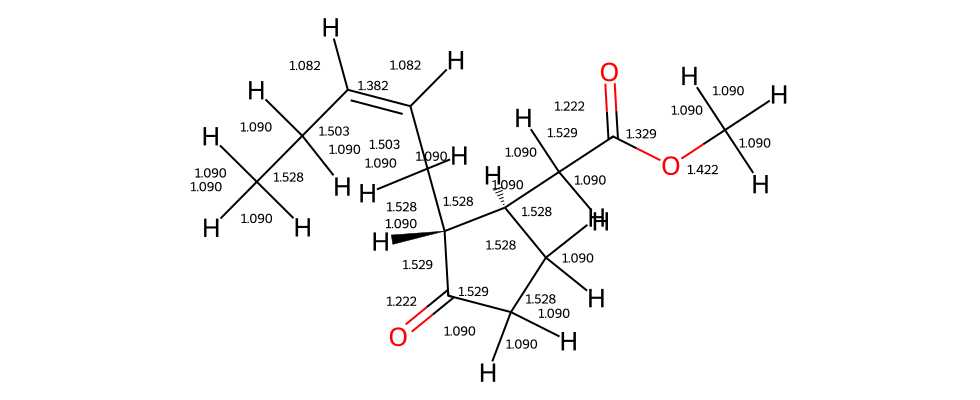

In [4]:
SMILES = r"O=C1[C@H](C/C=C\CC)[C@@H](CC(OC)=O)CC1"

draw_molecule(SMILES, bond_notes=get_bond_lengths(SMILES))

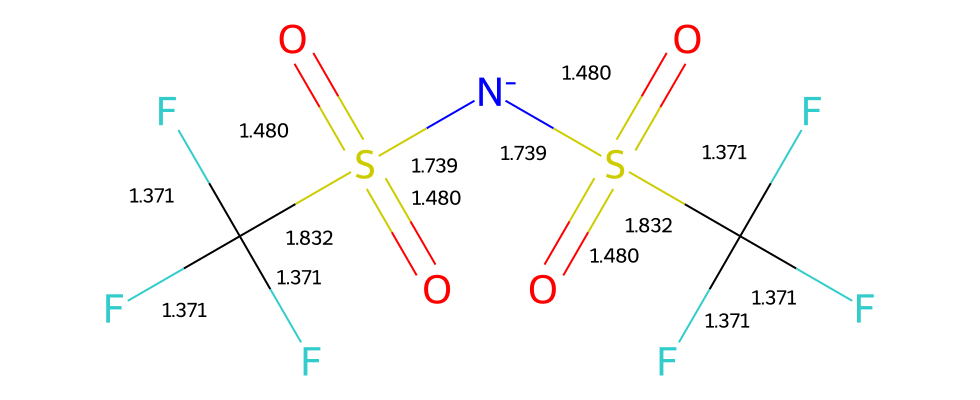

In [5]:
SMILES = r"C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F"
draw_molecule(SMILES, bond_notes=get_bond_lengths(SMILES))